# 1. CNN Pytorch

In [6]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

In [9]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Using device:", device)

Using device: mps


In [10]:
transform = transforms.Compose([
    transforms.ToTensor(), #tranform numpy or PIL to Tensor and at the same time devide by 255, so becomes 0-1 float32
    transforms.Normalize((0.1307,), (0.3081,)) #0.1307 and 0.3081 is mean and std of mnist data, this step is normalization
])

train_ds_full = datasets.MNIST(root="./data", train=True, download=True, transform=transform) #will add train set, if not download will download
test_ds = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|█| 9912422/9912422 [00:00<00:00, 12


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|█| 28881/28881 [00:00<00:00, 312578


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|█| 1648877/1648877 [00:00<00:00, 33


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|█| 4542/4542 [00:00<00:00, 1535094.

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### split training set into train/val

In [11]:
val_size = 10000
train_size = len(train_ds_full) - val_size
train_ds, val_ds = random_split(train_ds_full, [train_size, val_size])

### create data loader

In [12]:
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

### define the model architecture

In [21]:
class TorchCNN(nn.Module):
    def __init__(self, p_drop=0.5):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1) #default stride=1; padding=1, kernel_size=3, stride=1 combine keep the shape
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.drop = nn.Dropout(p_drop)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)    #Flatten # or x = x.flatten(1)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)    #output logits
        return x
        #x shape: N*1*28*28 (NCHW) gray, only one channel
        #conv1 -> relu -> pool: N*32*28*28 -> N*32*28*28 -> N*32*14*14
        #conv2 -> relu -> pool: N*64*14*14 -> N*64*14*14 -> N*64*7*7
        #fc1: N*128
        #fc2: N*10 

### evaluate

In [22]:
def evaluate(model, loader, criterion):
    model.eval()
    tot_loss, tot_correct, tot = 0.0, 0, 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            tot_loss += loss.item() * xb.size(0)
            pred = logits.argmax(dim=1)
            tot_correct += (pred == yb).sum().item()
            tot += xb.size(0)
    return tot_loss / tot, tot_correct / tot

### train with early stopping

In [29]:
def train(model, train_loader, val_loader, epochs=20, lr=1e-3, weight_decay=5e-4, patience=5):
    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay) #L2 regularization
    criterion = nn.CrossEntropyLoss()

    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    best_val = float("inf")
    best_state = None
    wait = 0

    for epoch in range(1, epochs + 1):
        model.train()
        t0 = time.time()

        train_loss_sum, train_correct, train_total = 0.0, 0, 0
        
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            opt.step()

            bs = xb.size(0)
            train_loss_sum += loss.item() * bs
            with torch.no_grad():
                pred = logits.argmax(dim=1)
                train_correct += (pred == yb).sum().item()
            train_total += bs

        epoch_train_loss = train_loss_sum / train_total
        epoch_train_acc  = train_correct / train_total
        
        val_loss, val_acc = evaluate(model, val_loader, criterion)
        print(f"Epoch {epoch:02d} | val_loss={val_loss:.4f} val_acc={val_acc:.4f} ({time.time()-t0:.1f}s)")

        history["train_loss"].append(epoch_train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(epoch_train_acc)
        history["val_acc"].append(val_acc)
        
        #early stopping
        if val_loss < best_val:
            best_val = val_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping.")
                break

    if best_state is not None:
        model.load_state_dict(best_state)
    test_loss, test_acc = evaluate(model, test_loader, nn.CrossEntropyLoss())
    print(f"Test: loss={test_loss:.4f}, acc={test_acc:.4f}")

    return history

### Train model

In [32]:
model = TorchCNN(p_drop=0.5)
history = train(model, train_loader, val_loader, epochs=20, lr=1e-3, weight_decay=5e-4, patience=5)

Epoch 01 | val_loss=0.0779 val_acc=0.9760 (6.7s)
Epoch 02 | val_loss=0.0516 val_acc=0.9843 (6.1s)
Epoch 03 | val_loss=0.0460 val_acc=0.9860 (6.1s)
Epoch 04 | val_loss=0.0395 val_acc=0.9872 (6.0s)
Epoch 05 | val_loss=0.0438 val_acc=0.9854 (6.1s)
Epoch 06 | val_loss=0.0344 val_acc=0.9885 (6.1s)
Epoch 07 | val_loss=0.0359 val_acc=0.9891 (6.1s)
Epoch 08 | val_loss=0.0406 val_acc=0.9862 (6.1s)
Epoch 09 | val_loss=0.0350 val_acc=0.9891 (6.0s)
Epoch 10 | val_loss=0.0342 val_acc=0.9878 (6.0s)
Epoch 11 | val_loss=0.0369 val_acc=0.9887 (6.1s)
Epoch 12 | val_loss=0.0341 val_acc=0.9891 (6.2s)
Epoch 13 | val_loss=0.0287 val_acc=0.9913 (6.1s)
Epoch 14 | val_loss=0.0391 val_acc=0.9870 (6.0s)
Epoch 15 | val_loss=0.0354 val_acc=0.9890 (5.9s)
Epoch 16 | val_loss=0.0322 val_acc=0.9888 (6.0s)
Epoch 17 | val_loss=0.0379 val_acc=0.9875 (6.0s)
Epoch 18 | val_loss=0.0292 val_acc=0.9905 (6.1s)
Early stopping.
Test: loss=0.0234, acc=0.9921


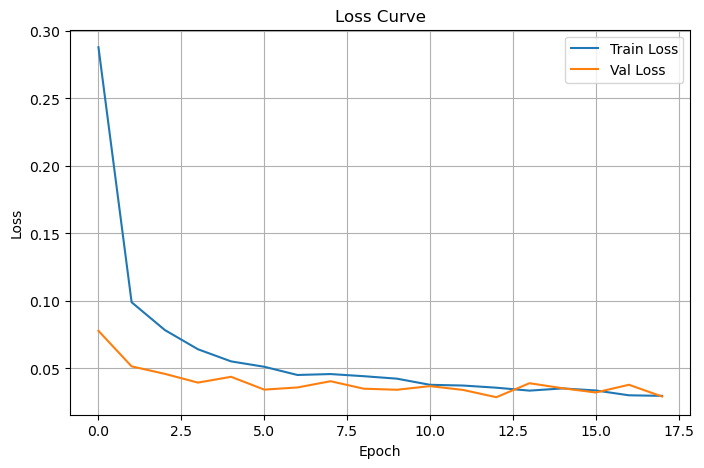

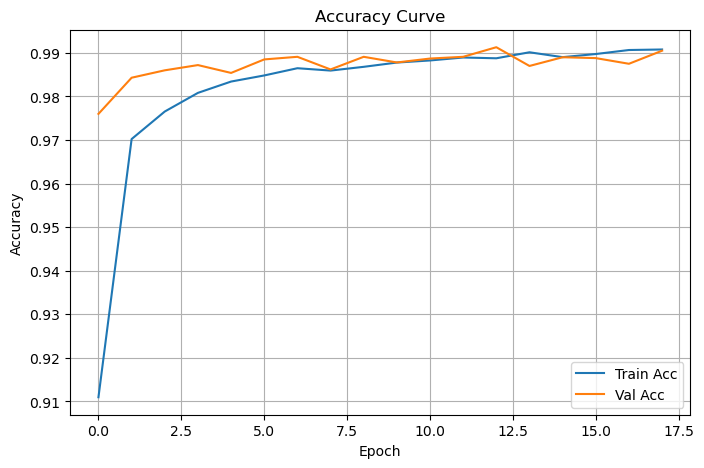

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"],   label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss Curve"); plt.grid(True); plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"],   label="Val Acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy Curve"); plt.grid(True); plt.legend()
plt.show()

# 2. Tensorflow CNN

In [34]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

In [35]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train = (X_train.astype("float32") / 255.0)[..., None]
X_test = (X_test.astype("float32") / 255.0)[..., None] #same to numpy np.newaxis, here[..., None] is insert a dimention at the end

In [36]:
val_split = 1000
X_val, y_val = X_train[-val_split:], y_train[-val_split:]
X_train, y_train = X_train[:-val_split], y_train[:-val_split]

### define CNN model with L2 regularization

In [39]:
l2 = keras.regularizers.l2(5e-4)
model = keras.Sequential([
    layers.Conv2D(32, 3, padding="same", activation="relu", kernel_regularizer=l2, input_shape=(28, 28, 1)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding="same", activation="relu", kernel_regularizer=l2),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation="relu", kernel_regularizer=l2),
    layers.Dropout(0.5),
    layers.Dense(10),
])

### compile model

In [40]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

### early stopping

In [41]:
early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

### train model

In [42]:
history = model.fit(
    X_train, y_train,
    batch_size=128,
    epochs=20, validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=2
)

Epoch 1/20


2025-08-11 21:10:15.841581: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


461/461 - 9s - loss: 0.4047 - accuracy: 0.9088 - val_loss: 0.1787 - val_accuracy: 0.9830 - 9s/epoch - 20ms/step
Epoch 2/20
461/461 - 9s - loss: 0.1882 - accuracy: 0.9696 - val_loss: 0.1557 - val_accuracy: 0.9860 - 9s/epoch - 19ms/step
Epoch 3/20
461/461 - 9s - loss: 0.1619 - accuracy: 0.9737 - val_loss: 0.1339 - val_accuracy: 0.9890 - 9s/epoch - 19ms/step
Epoch 4/20
461/461 - 9s - loss: 0.1431 - accuracy: 0.9785 - val_loss: 0.1271 - val_accuracy: 0.9910 - 9s/epoch - 19ms/step
Epoch 5/20
461/461 - 9s - loss: 0.1364 - accuracy: 0.9791 - val_loss: 0.1307 - val_accuracy: 0.9880 - 9s/epoch - 19ms/step
Epoch 6/20
461/461 - 9s - loss: 0.1296 - accuracy: 0.9799 - val_loss: 0.1161 - val_accuracy: 0.9900 - 9s/epoch - 20ms/step
Epoch 7/20
461/461 - 10s - loss: 0.1258 - accuracy: 0.9813 - val_loss: 0.1151 - val_accuracy: 0.9910 - 10s/epoch - 21ms/step
Epoch 8/20
461/461 - 9s - loss: 0.1204 - accuracy: 0.9816 - val_loss: 0.1174 - val_accuracy: 0.9890 - 9s/epoch - 19ms/step
Epoch 9/20
461/461 - 9s -

In [44]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test: loss={test_loss:.4f}, acc={test_acc:.4f}")

Test: loss=0.0786, acc=0.9908


Best val_loss at epoch 20: 0.0967


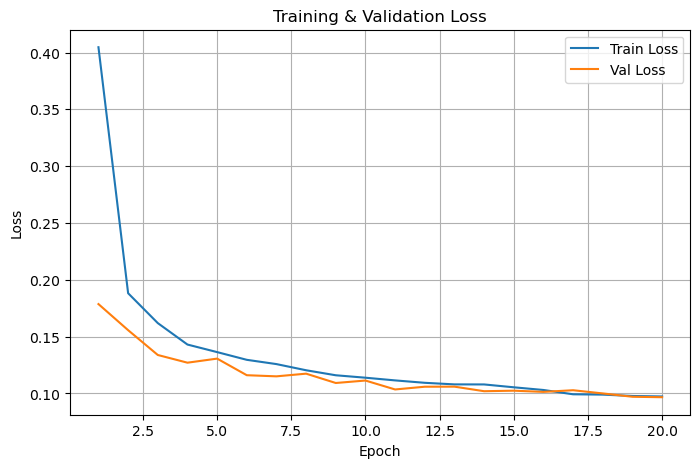

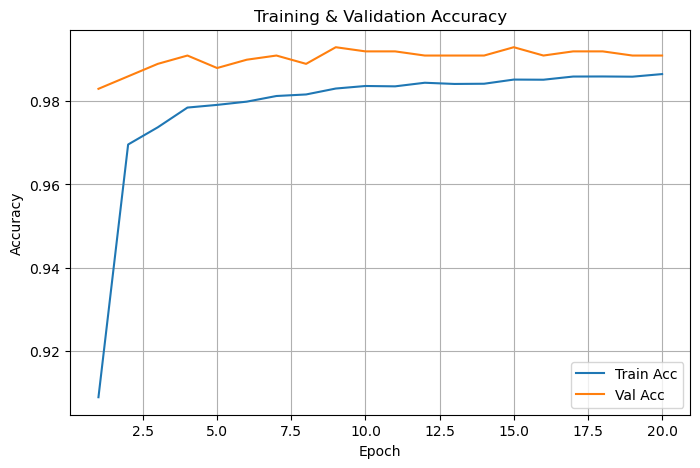

In [45]:
import numpy as np

# 从 History 中取出曲线
train_loss = history.history["loss"]
val_loss   = history.history["val_loss"]
train_acc  = history.history["accuracy"]
val_acc    = history.history["val_accuracy"]

epochs_r = range(1, len(train_loss) + 1)

# 找到最优 val_loss 的 epoch（可选）
best_epoch = int(np.argmin(val_loss) + 1)
print(f"Best val_loss at epoch {best_epoch}: {val_loss[best_epoch-1]:.4f}")

# ---- 画 Loss 曲线
plt.figure(figsize=(8, 5))
plt.plot(epochs_r, train_loss, label="Train Loss")
plt.plot(epochs_r, val_loss,   label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training & Validation Loss")
plt.legend(); plt.grid(True)
plt.show()

# ---- 画 Accuracy 曲线
plt.figure(figsize=(8, 5))
plt.plot(epochs_r, train_acc, label="Train Acc")
plt.plot(epochs_r, val_acc,   label="Val Acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Training & Validation Accuracy")
plt.legend(); plt.grid(True)
plt.show()

# 3. Numpy Dropout and L2 regularization

In [46]:
np.random.seed(0)


In [47]:
def make_blobs(n_samples=600, n_features=2, centers=3, std=1.2):
    X, y = [], []
    for c in range(centers):
        mean = np.random.uniform(-5, 5, size=(n_features,))
        cov = (std ** 2) * np.eye(n_features)
        Xi = np.random.multivariate_normal(mean, cov, size=n_samples//centers)
        yi = np.full((n_samples//centers,), c, dtype=int)
        X.append(Xi)
        y.append(yi)
    X = np.vstack(X)
    y = np.concatenate(y)
    idx = np.random.permutation(len(X))
    return X[idx], y[idx]

In [48]:
def visualize(X, y):
    plt.figure(figsize=(6, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis", s=30, alpha=0.8, edgecolor="k")
    plt.title("make_blobs Generated Data")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.grid(True)
    plt.show()

In [49]:
def one_hot(y, C):
    Y = np.zeros((y.size, C))
    Y[np.arange(y.size), y] = 1
    return Y

In [50]:
class MLP:
    def __init__(self, in_dim, hidden, out_dim, keep_prob=0.7, l2=1e-3):
        self.W1 = np.random.randn(in_dim, hidden) * np.sqrt(2.0 / in_dim) #he initialization
        self.b1 = np.zeros((1, hidden))
        self.W2 = np.random.randn(hidden, out_dim) * np.sqrt(2.0 / hidden)
        self.b2 = np.zeros((1, out_dim))
        self.keep_prob = keep_prob
        self.l2 = l2
        self.training = True
        self._dropout_mask = None

    def forward(self, X):
        Z1 = X @ self.W1 + self.b1
        A1 = np.maximum(0, Z1) #relu
        if self.training:
            mask = (np.random.rand(*A1.shape) < self.keep_prob).astype(A1.dtype)
            A1 = A1 * mask / self.keep_prob
            self._dropout_mask = mask
        else:
            self._dropout_mask = None

        Z2= A1 @ self.W2 + self.b2
        return Z1, A1, Z2

    def loss_and_grads(self, X, y):
        Z1, A1, Z2 = self.forward(X)
        logits = Z2 - Z2.max(axis=1, keepdims=True) #after exp, results wont change, this way can avoid exp(large number)
        exp = np.exp(logits)
        probs = exp / np.sum(exp, axis=1, keepdims=True)

        N = X.shape[0]
        y1 = one_hot(y, probs.shape[1])
        data_loss = -np.sum(y1 * np.log(probs + 1e-9)) / N
        reg_loss = 0.5 * self.l2 * (np.sum(self.W1 ** 2) + np.sum(self.W2 ** 2))
        loss = data_loss + reg_loss

        dZ2 = (probs - y1) / N
        dW2 = A1.T @ dZ2 + self.l2 * self.W2
        db2 = dZ2.sum(axis=0, keepdims=True)

        dA1 = dZ2 @ self.W2.T
        if self._dropout_mask is not None:
            dA1 = dA1 * self._dropout_mask / self.keep_prob
        dZ1 = dA1 * (Z1 > 0)
        dW1 = X.T @ dZ1 + self.l2 * self.W1
        db1 = dZ1.sum(axis=0, keepdims=True)

        grads = {"W1": dW1, "b1": db1, "W2": dW2, "b2": db2}
        return loss, grads

    def step(self, grads, lr=5e-2):
        for k, g in grads.items():
            setattr(self, k, getattr(self, k) - lr * g)

In [51]:
def accuracy(model, X, y):
    model.training = False
    _, _, Z2 = model.forward(X)
    preds = Z2.argmax(axis=1)
    return (preds == y).mean()

### Split data

In [58]:
X, y = make_blobs()

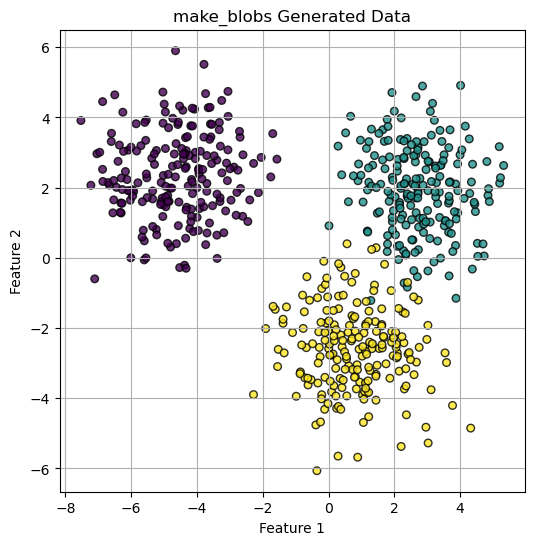

In [59]:
visualize(X, y)

In [60]:
split = int(0.8 * len(X))
X_train, y_train = X[:split], y[:split]
X_val,   y_val   = X[split:], y[split:]

In [61]:
mlp = MLP(in_dim=2, hidden=64, out_dim=3, keep_prob=0.7, l2=1e-3)

In [62]:
best_val = float("inf")
best_params = None
patience = 20
wait = 0

In [64]:
for epoch in range(1, 501):
    mlp.training = True
    loss, grads = mlp.loss_and_grads(X_train, y_train)
    mlp.step(grads, lr=5e-2)

    mlp.training = False
    val_loss, _ = mlp.loss_and_grads(X_val, y_val)

    if epoch % 5 == 0:
        acc_tr = accuracy(mlp, X_train, y_train)
        acc_va = accuracy(mlp, X_val, y_val)
        print(f"Epoch {epoch:03d} | loss={loss:.4f} val_loss={val_loss:.4f} acc_tr={acc_tr:.3f} acc_va={acc_va:.3f}")

    if val_loss < best_val:
        best_val = val_loss
        best_params = {k: getattr(mlp, k).copy() for k in ["W1", "b1", "W2", "b2"]}
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping")
            break

if best_params is not None:
    for k, v in best_params.items():
        setattr(mlp, k, v)

print("Final acc (train/val):", accuracy(mlp, X_train, y_train), accuracy(mlp, X_val, y_val))

Epoch 005 | loss=0.1436 val_loss=0.1310 acc_tr=0.992 acc_va=0.975
Epoch 010 | loss=0.0975 val_loss=0.1324 acc_tr=0.992 acc_va=0.975
Epoch 015 | loss=0.1172 val_loss=0.1327 acc_tr=0.992 acc_va=0.975
Epoch 020 | loss=0.1106 val_loss=0.1340 acc_tr=0.992 acc_va=0.975
Early stopping
Final acc (train/val): 0.9916666666666667 0.975
